In [1]:
from tensorflow import keras 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding , Flatten , Dense  ,LSTM ,Bidirectional
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import re 


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
downloaded =drive.CreateFile({'id':'16zuH2fyNU9_tjp3088edYDIxEfWEX7cb'})
downloaded.GetContentFile('texte.txt')

In [5]:
with open ('texte.txt') as f:
  lines = f.readlines()

In [6]:
data = [line.lower().strip() for line in lines ]

In [7]:
data = [line for line in data if len(line) >=3]

In [8]:
data

['au nom d’allah le tout-miséricordieux, le trèsmiséricordieux',
 'mon dieu ! accorde ta bénédiction à notre seigneur',
 'mohammed (صلى الله عليه وسلم (qui a ouvert ce qui était clos, qui a',
 'clos ce qui a précédé, le défenseur de la vérité par',
 'la vérité, le guide du droit chemin, ainsi qu’à sa',
 'famille suivant sa valeur et l’estimation de son',
 'ultime dignité.',
 'cheikh seydi el hadj malick sy (rta):le',
 "déferlement des vagues de l'immensité, la",
 'quête du retour',
 'comme une onde lumineuse, les vagues se',
 'réfléchissent, se diffractent et se réfractent sur le',
 'rivage.',
 'les vagues forment des rouleaux qui contiennent la',
 'perle et le corail où sont révélés les messages',
 "l'ensemble des vagues de la louange générées par",
 'le souffle de parfum de la hyacinthe rouge',
 'déferlent , se brisent en tourbillonnant , formant des',
 "bulles d'air, accélérant le courant de l'abondance",
 'on ne peut ni les dénombrer, encore moins évaluer',
 "les merveilles qu'elle

In [9]:
corpus = ""
for i in data:
  corpus += i+"\n"

corpus = corpus.lower().split("\n")
tokenizer =Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
total_word = len(word_index) +1

sequences  = tokenizer.texts_to_sequences (corpus)


In [10]:
input_sentences =[]

for line in corpus :
    list_token= tokenizer.texts_to_sequences([line])[0]
    for i in range (1 , len(list_token)):
        n_gram_sentences = list_token[:i+1]
        input_sentences.append(n_gram_sentences)
        
max_len_sentences = max([len(x) for x in  input_sentences])
print(max_len_sentences)
input_sentences = np.array(pad_sequences(input_sentences , maxlen=max_len_sentences , padding='pre'))

171


In [11]:
xs , labels = input_sentences[:,:-1] , input_sentences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_word)

In [12]:
model= Sequential([
    Embedding(total_word , 64 , input_length=max_len_sentences -1),
    Bidirectional(LSTM(20)),
    Dense(total_word/2 , activation='relu' , kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.02),
    Dense(total_word , activation ='sigmoid')
    
])

model.summary()

model.compile (loss='categorical_crossentropy' , optimizer = RMSprop(lr=0.001) , metrics =['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 170, 64)           262976    
_________________________________________________________________
bidirectional (Bidirectional (None, 40)                13600     
_________________________________________________________________
dense (Dense)                (None, 2054)              84214     
_________________________________________________________________
dropout (Dropout)            (None, 2054)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4109)              8443995   
Total params: 8,804,785
Trainable params: 8,804,785
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(xs , ys ,epochs =100 , verbose =1 )

Epoch 1/100
990/990 [==============================] - 28s 20ms/step - loss: 6.5597 - accuracy: 0.0626
Epoch 2/100
990/990 [==============================] - 19s 20ms/step - loss: 5.6161 - accuracy: 0.0867
Epoch 3/100
990/990 [==============================] - 19s 20ms/step - loss: 5.2817 - accuracy: 0.1472
Epoch 4/100
990/990 [==============================] - 19s 20ms/step - loss: 5.0155 - accuracy: 0.2465
Epoch 5/100
990/990 [==============================] - 19s 20ms/step - loss: 4.8263 - accuracy: 0.2860
Epoch 6/100
990/990 [==============================] - 20s 20ms/step - loss: 4.7224 - accuracy: 0.3007
Epoch 7/100
990/990 [==============================] - 19s 20ms/step - loss: 4.6573 - accuracy: 0.3052
Epoch 8/100
990/990 [==============================] - 19s 20ms/step - loss: 4.5897 - accuracy: 0.3130
Epoch 9/100
990/990 [==============================] - 19s 19ms/step - loss: 4.5644 - accuracy: 0.3181
Epoch 10/100
990/990 [==============================] - 19s 20ms/step - l

In [20]:
model.save("my_model.h5")

In [21]:
def graph_plot (history , string):
    plt.plot(history.history[string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string])
    plt.show()

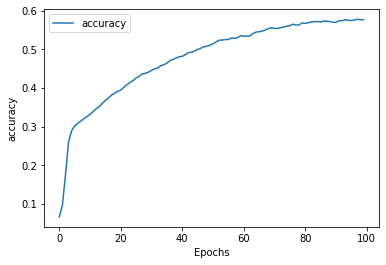

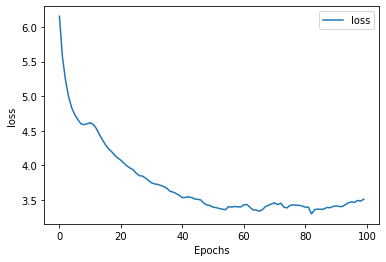

In [22]:
graph_plot(history , 'accuracy')
graph_plot(history , 'loss')

In [26]:
seed_text = "Maodo"
next_word =100

for _ in range (next_word):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list] , maxlen=max_len_sentences -1 , padding='pre')
    predicted = model.predict_classes(token_list , verbose=0)
    output_word = ""
    for word , index in tokenizer.word_index.items():
        if index == predicted :
            output_word = word
            break 
    seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Maodo                                                                                                    
